In [3]:
#!pip install jdatetime
#!pip install feature_engine

In [4]:
import pandas as pd
import numpy as np
import jdatetime
import matplotlib.pyplot as plt
import datetime
from feature_engine.outliers import Winsorizer
from sklearn.cluster import KMeans
import seaborn as sns
from scipy import stats
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
#Read data and Convert Date column to DateTime format
df = pd.read_csv('Dataset.csv', index_col = 0, parse_dates=[3])
df.sample(5)

,CustomerID,OrderID,Date,Revenue
155944,7172126,46759555,2019-12-03,8256
42854,11650327,38696028,2019-07-27,5467
155878,14828749,46808719,2019-12-03,10605
216892,2619375,51697608,2020-02-04,5100
140990,9172309,45338554,2019-11-17,7320


In [6]:
print(df.shape)
df=df.drop_duplicates()
print(df.shape)

(261960, 4)
(261960, 4)


In [7]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
CustomerID,CustomerID,0.0
OrderID,OrderID,0.0
Date,Date,0.0
Revenue,Revenue,0.0


# Task 1

In [8]:
#Extracr Shamsi from Gregorian Date
def extract_shamsi(df):
    #Extract day, month, year in Shamsi format
    for index, row in df.iterrows():
        df.loc[index,'ShamsiYear'] = int(jdatetime.date.fromgregorian(date = row['Date']).year)
        df.loc[index,'ShamsiMonth'] = int(jdatetime.date.fromgregorian(date = row['Date']).month)
        df.loc[index,'ShamsiDay'] = int(jdatetime.date.fromgregorian(date = row['Date']).day)

    #Convert to int
    df.ShamsiYear = df.ShamsiYear.astype('int')
    df.ShamsiMonth = df.ShamsiMonth.astype('int')
    df.ShamsiDay = df.ShamsiDay.astype('int')
    
    return df

In [9]:
df = extract_shamsi(df)
       
shamsi_month_dict = {1:'Fardvardin', 2:'Ordibehesht', 3:'Khordad', 4:'Tir', 5:'Mordad', 6:'Shahrivar',
                     7:'Mehr', 8:'Aban', 9:'Azar', 10:'Dey', 11:'Bahman', 12:'Esfand'} 
# df['ShamsiMonth'] = df['ShamsiMonth'].replace(shamsi_month_dict)

In [10]:
#Select 1398 Data
df_1398 = df[df['ShamsiYear'] == 1398]

## Number of Customers in each month of 1398

In [11]:
customer_by_month = df_1398.groupby('ShamsiMonth').agg('nunique')[['CustomerID']]
customer_by_month.rename(columns = {'CustomerID':'Number_of_customers'}, inplace = True)
customer_by_month

,Number_of_customers
ShamsiMonth,
1,2789
2,3064
3,12768
4,14122
5,24708
6,16603
7,22541
8,28594
9,27344


<AxesSubplot:xlabel='ShamsiMonth', ylabel='Number_of_customers'>

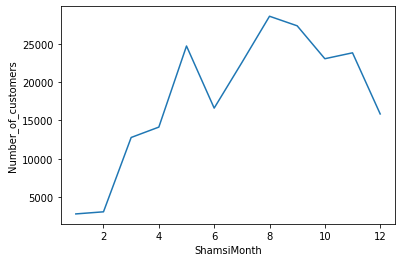

In [12]:
sns.lineplot(data=customer_by_month["Number_of_customers"])

## Number of Orders in each month of 1398

In [13]:
num_order_by_month = df_1398.groupby('ShamsiMonth').agg('count')[['OrderID']]
num_order_by_month.rename(columns = {'OrderID':'Number_of_orders'}, inplace = True)
num_order_by_month

,Number_of_orders
ShamsiMonth,
1,3279
2,3503
3,14380
4,16228
5,28663
6,18630
7,26699
8,33233
9,30989


<AxesSubplot:xlabel='ShamsiMonth', ylabel='Number_of_orders'>

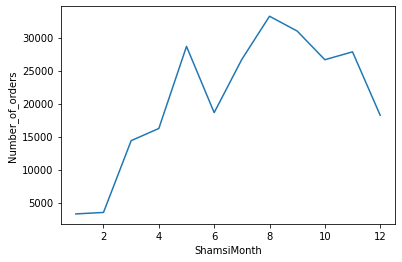

In [14]:
sns.lineplot(data=num_order_by_month["Number_of_orders"])

## Average Order Value in each month of 1398

In [15]:
avg_order_value_by_month = df_1398.groupby('ShamsiMonth').agg('mean')[['Revenue']]
avg_order_value_by_month.rename(columns = {'Revenue':'Average_order_value'}, inplace = True)
avg_order_value_by_month

,Average_order_value
ShamsiMonth,
1,5983.073803
2,6811.412789
3,6353.511335
4,6615.135815
5,5111.210864
6,5602.548631
7,5641.541031
8,5506.903259
9,5821.103714


<AxesSubplot:xlabel='ShamsiMonth', ylabel='Average_order_value'>

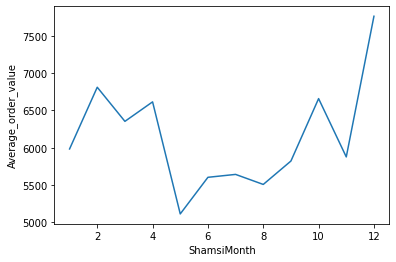

In [16]:
sns.lineplot(data=avg_order_value_by_month["Average_order_value"])

## Average frequency in each month of 1398

In [17]:
avg_frequency_by_month = df_1398.groupby('ShamsiMonth').agg({'OrderID':len, 'CustomerID':'nunique'})
avg_frequency_by_month.rename(columns={'OrderID': 'Num_order', 'CustomerID':'Num_unique_customer'}, inplace = True)
avg_frequency_by_month['avg_freq'] = avg_frequency_by_month['Num_order'] / avg_frequency_by_month['Num_unique_customer']
avg_frequency_by_month

,Num_order,Num_unique_customer,avg_freq
ShamsiMonth,,,
1,3279,2789,1.175690
2,3503,3064,1.143277
3,14380,12768,1.126253
4,16228,14122,1.149129
5,28663,24708,1.160070
6,18630,16603,1.122086
7,26699,22541,1.184464
8,33233,28594,1.162237
9,30989,27344,1.133302


<AxesSubplot:xlabel='ShamsiMonth', ylabel='avg_freq'>

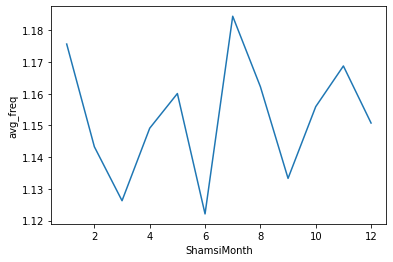

In [18]:
sns.lineplot(data=avg_frequency_by_month["avg_freq"])

## Total revenue in each month of 1398

In [19]:
total_revenue_by_month = df_1398.groupby('ShamsiMonth').agg('sum')[['Revenue']]
total_revenue_by_month.rename(columns = {'Revenue':'Total_revenue'}, inplace = True)
total_revenue_by_month

,Total_revenue
ShamsiMonth,
1,19618499
2,23860379
3,91363493
4,107350424
5,146502637
6,104375481
7,150623504
8,183010916
9,180390183


<AxesSubplot:xlabel='ShamsiMonth', ylabel='Total_revenue'>

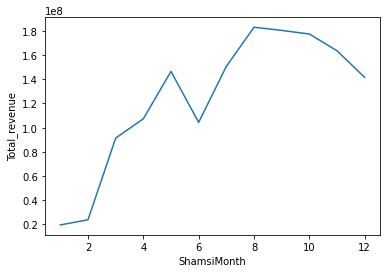

In [20]:
sns.lineplot(data=total_revenue_by_month["Total_revenue"])

# Task 2

## Month with highest order

In [21]:
month_num = num_order_by_month.Number_of_orders.idxmax()
print(f'Month with highest order: {shamsi_month_dict[month_num]}')

Month with highest order: Aban


## Month with highest revenue

In [22]:
month_num = total_revenue_by_month.Total_revenue.idxmax()
print(f'Month with highest revenue: {shamsi_month_dict[month_num]}')

Month with highest revenue: Aban


# Task 3

In [23]:
#6month before last order
start_date = df.Date.max() - datetime.timedelta(days=183)

#Date of last order(For calculating recency)
finish_date = df.Date.max()

print(start_date)
print(finish_date)

2019-10-19 00:00:00
2020-04-19 00:00:00


In [24]:
#Select last 6 month data
df_last_6_month = df[df.Date >= start_date]
df_last_6_month

,CustomerID,OrderID,Date,Revenue,ShamsiYear,ShamsiMonth,ShamsiDay
107594,8638244,43490933,2019-10-19,730,1398,7,27
107595,1420405,43489108,2019-10-19,2360,1398,7,27
107596,13700179,43507419,2019-10-19,1464,1398,7,27
107597,13051245,43510169,2019-10-19,730,1398,7,27
107598,3280852,43465862,2019-10-19,7560,1398,7,27
...,...,...,...,...,...,...,...
261955,14814009,58778867,2020-04-19,8760,1399,1,31
261956,17043123,58761937,2020-04-19,5240,1399,1,31
261957,2853558,58757250,2020-04-19,8760,1399,1,31
261958,3114170,58818638,2020-04-19,11920,1399,1,31


# Extract RFM feautures from data

**Since there is no duplicate OrderId, there is no need to calculate number of uniques OrderID.**

In [25]:
#Calculate recency, frequency and monetary for each customer
RFMScores = df_last_6_month.groupby('CustomerID').agg({'Date': lambda x: (finish_date - x.max()).days,
                                                       'OrderID': lambda x: x.nunique(),
                                                       'Revenue': lambda x: x.sum()})

RFMScores.rename(columns={'Date':'Recency',
                          'OrderID':'Frequency',
                          'Revenue':'Monetary'}, inplace=True)
RFMScores

,Recency,Frequency,Monetary
CustomerID,,,
465132,141,1,7302
465164,51,1,578
465198,6,1,5688
465204,168,1,1464
465211,88,1,4760
...,...,...,...
46144731,108,1,2360
46188806,151,1,9160
46380582,22,1,13520


## RFM Analysis

In [26]:
#Segment each attribute
quantiles = RFMScores.quantile(q=[0.2,0.4,0.6, 0.8])
quantiles = quantiles.to_dict()

def RScore(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 4
    else:
        return 5
    
def FMScore(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 2
    else:
        return 1

#Quantile R,F,M to 5 quantile
RFMScores['R'] = RFMScores['Recency'].apply(RScore, args=('Recency',quantiles))
RFMScores['F'] = RFMScores['Frequency'].apply(FMScore, args=('Frequency',quantiles))
RFMScores['M'] = RFMScores['Monetary'].apply(FMScore, args=('Monetary',quantiles))

#Grouping R,F,M
RFMScores['Segment'] = RFMScores.R.map(str)+RFMScores.F.map(str)+RFMScores.M.map(str)
RFMScores

,Recency,Frequency,Monetary,R,F,M,Segment
CustomerID,,,,,,,
465132,141,1,7302,4,5,2,452
465164,51,1,578,1,5,5,155
465198,6,1,5688,1,5,3,153
465204,168,1,1464,5,5,5,555
465211,88,1,4760,3,5,3,353
...,...,...,...,...,...,...,...
46144731,108,1,2360,3,5,4,354
46188806,151,1,9160,4,5,2,452
46380582,22,1,13520,1,5,1,151


## EDA

In [68]:
#Apply k-means
cluster_df = RFMScores[['Recency', 'Frequency', 'Monetary']]
cluster_df

,Recency,Frequency,Monetary
CustomerID,,,
465132,141,1,7302
465164,51,1,578
465198,6,1,5688
465204,168,1,1464
465211,88,1,4760
...,...,...,...
46144731,108,1,2360
46188806,151,1,9160
46380582,22,1,13520


In [28]:
cluster_df.corr()

,Recency,Frequency,Monetary
Recency,1.000000,-0.151789,-0.133704
Frequency,-0.151789,1.000000,0.878025
Monetary,-0.133704,0.878025,1.000000


<AxesSubplot:xlabel='Recency', ylabel='Monetary'>

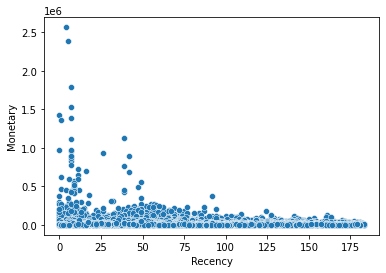

In [29]:
sns.scatterplot(data=cluster_df, x="Recency", y="Monetary")

<AxesSubplot:xlabel='Recency', ylabel='Frequency'>

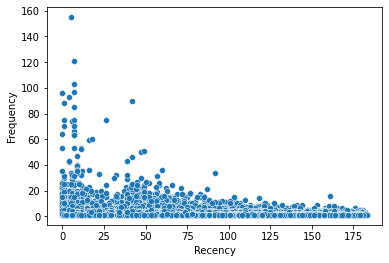

In [30]:
sns.scatterplot(data=cluster_df, x="Recency", y="Frequency")

<AxesSubplot:xlabel='Frequency', ylabel='Monetary'>

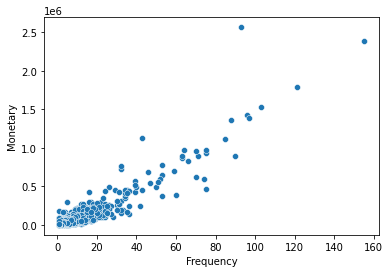

In [31]:
sns.scatterplot(data=cluster_df, x="Frequency", y="Monetary")

In [32]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Recency's: Skew: -0.185444510106593, : SkewtestResult(statistic=-25.42380156957226, pvalue=1.3760564446420927e-142)


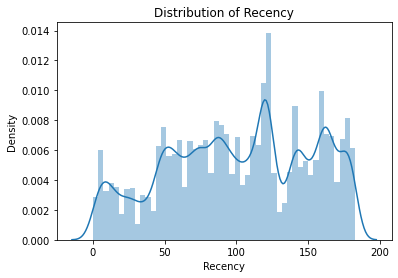

In [33]:
check_skew(cluster_df, 'Recency')

Frequency's: Skew: 28.146225761601684, : SkewtestResult(statistic=477.94481274085166, pvalue=0.0)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


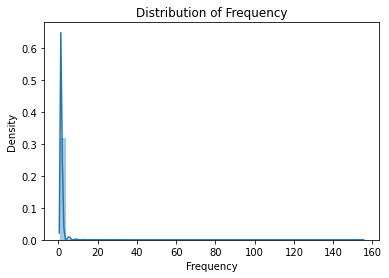

In [34]:
check_skew(cluster_df, 'Frequency')

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Monetary's: Skew: 47.654202544332364, : SkewtestResult(statistic=537.376871871988, pvalue=0.0)


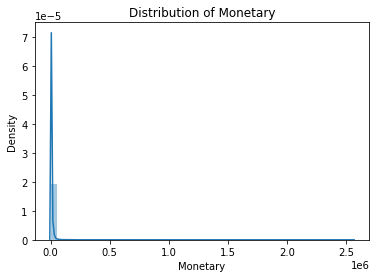

In [35]:
check_skew(cluster_df, 'Monetary')

In [69]:
#Removing Skewness
cluster_df = np.log(cluster_df+1)

#Windsoriser
windsoriser = Winsorizer(tail='both', fold=2, variables=['Recency', 'Frequency', 'Monetary'])
windsoriser.fit(cluster_df)
cluster_df = windsoriser.transform(cluster_df)

## Outlier Detection


**Since removing outliers, remove lots of useful data, We skip this part and use Windsorisinz instead.**

In [58]:
def remove_outliers(df, col):
    #plt.boxplot(df[col])
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[col] >= Q1 - 1.5*IQR) & (df[col] <= Q3 + 1.5*IQR)]
    return df

# for var in ['Recency', 'Frequency', 'Monetary']:
#     cluster_df = remove_outliers(cluster_df, var)  
# cluster_df

,Recency,Frequency,Monetary
CustomerID,,,
465132,4.955827,0.693147,8.896041
465164,3.951244,0.693147,6.364914
465204,5.129899,0.693147,7.289611
465211,4.488636,0.693147,8.468213
465279,4.691348,0.693147,7.581210
...,...,...,...
46110761,5.062595,0.693147,8.967122
46144731,4.691348,0.693147,7.766841
46188806,5.023881,0.693147,9.122711


## Scaling

In [70]:
#Bring the data on same scale(Min-Max)
# scaler = MinMaxScaler()
# Scaled_Data = scaler.fit_transform(cluster_df)
    
#Bring the data on same scale(StandardScaler)
scaler = StandardScaler()
Scaled_Data = scaler.fit_transform(cluster_df)

#Transform it back to dataframe
cluster_df = pd.DataFrame(Scaled_Data, index = cluster_df.index, columns = cluster_df.columns)
cluster_df

,Recency,Frequency,Monetary
CustomerID,,,
465132,0.744656,-0.428804,0.395902
465164,-0.757802,-0.428804,-2.137556
465198,-2.550891,-0.428804,0.145921
465204,1.004998,-0.428804,-1.212008
465211,0.045924,-0.428804,-0.032320
...,...,...,...
46144731,0.349100,-0.428804,-0.734338
46188806,0.846437,-0.428804,0.622781
46380582,-1.977839,-0.428804,1.012428


## K-Means

Text(0.5, 1.0, 'Elbow Curve to find optimum K')

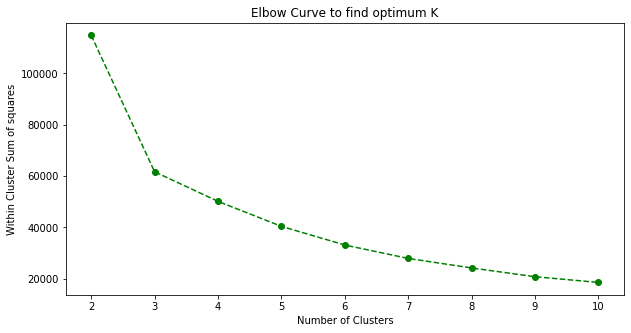

In [60]:
k = list(range(2,11))
sum_of_squared_distances = []
sse_ = []

for i in k:
    kmeans = KMeans(n_clusters=i, init= 'k-means++', max_iter= 1000)
    kmeans.fit(cluster_df)
    sum_of_squared_distances.append(kmeans.inertia_)
    #sse_.append(silhouette_score(cluster_df, kmeans.labels_))

plt.figure(figsize=(10, 5))
plt.plot(k, sum_of_squared_distances, 'go--')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of squares')
plt.title('Elbow Curve to find optimum K')

In [71]:
#Create Model
model = KMeans(n_clusters = 3, init= 'k-means++', max_iter= 1000)
#Training the model
model.fit(cluster_df)
#Predicting
y_pred = model.fit_predict(cluster_df)
# Storing the y_pred values in a new column(Cluster 1 to k)
pred_3 = cluster_df.copy()
pred_3['Cluster'] = y_pred + 1
pred_3

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
465132,0.744656,-0.428804,0.395902,1
465164,-0.757802,-0.428804,-2.137556,1
465198,-2.550891,-0.428804,0.145921,3
465204,1.004998,-0.428804,-1.212008,1
465211,0.045924,-0.428804,-0.032320,1
...,...,...,...,...
46144731,0.349100,-0.428804,-0.734338,1
46188806,0.846437,-0.428804,0.622781,1
46380582,-1.977839,-0.428804,1.012428,3


<AxesSubplot:xlabel='Recency', ylabel='Monetary'>

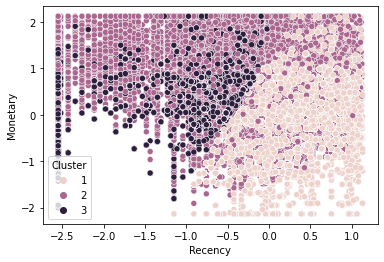

In [72]:
sns.scatterplot(data=pred_3, x="Recency", y="Monetary", hue='Cluster')

In [73]:
cluster_df

,Recency,Frequency,Monetary
CustomerID,,,
465132,0.744656,-0.428804,0.395902
465164,-0.757802,-0.428804,-2.137556
465198,-2.550891,-0.428804,0.145921
465204,1.004998,-0.428804,-1.212008
465211,0.045924,-0.428804,-0.032320
...,...,...,...
46144731,0.349100,-0.428804,-0.734338
46188806,0.846437,-0.428804,0.622781
46380582,-1.977839,-0.428804,1.012428


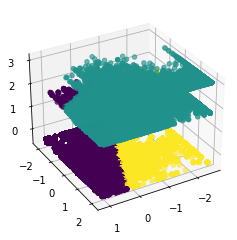

In [74]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=pred_3['Recency']
yline=pred_3['Frequency']
zline=pred_3['Monetary']

ax.scatter3D(xline, zline,yline,c=pred_3['Cluster'])
ax.view_init(30, 60)

In [75]:
#Create Model
model = KMeans(n_clusters = 4, init= 'k-means++', max_iter= 1000)
#Training the model
model.fit(cluster_df)
#Predicting
y_pred = model.fit_predict(cluster_df)
# Storing the y_pred values in a new column(Cluster 1 to k)
pred_4 = cluster_df.copy()
pred_4['Cluster'] = y_pred + 1
pred_4

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
465132,0.744656,-0.428804,0.395902,3
465164,-0.757802,-0.428804,-2.137556,2
465198,-2.550891,-0.428804,0.145921,4
465204,1.004998,-0.428804,-1.212008,2
465211,0.045924,-0.428804,-0.032320,3
...,...,...,...,...
46144731,0.349100,-0.428804,-0.734338,2
46188806,0.846437,-0.428804,0.622781,3
46380582,-1.977839,-0.428804,1.012428,4


<AxesSubplot:xlabel='Recency', ylabel='Monetary'>

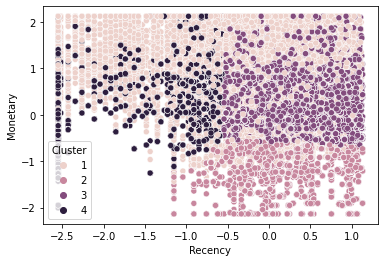

In [76]:
sns.scatterplot(data=pred_4, x="Recency", y="Monetary", hue='Cluster')

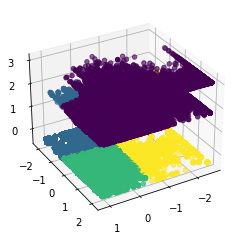

In [77]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=pred_4['Recency']
yline=pred_4['Frequency']
zline=pred_4['Monetary']

ax.scatter3D(xline, zline,yline,c=pred_4['Cluster'])
ax.view_init(30, 60)

# Task 4 (Bonus)

In [50]:
#Finding join date
farvardin_df = df.groupby('CustomerID').agg('min')[['Date']]

farvardin_df = extract_shamsi(farvardin_df)

#Select customers that join farvardin
farvardin_df = farvardin_df[farvardin_df.ShamsiMonth == 1]
join_farvardin_customers = list(farvardin_df.index)

#Select farvardin_joined_customer from base dataset
clv_df = df[df.CustomerID.isin(join_farvardin_customers)]
clv_df

,CustomerID,OrderID,Date,Revenue,ShamsiYear,ShamsiMonth,ShamsiDay
0,28448640,32937314,2019-03-21,5100,1398,1,1
1,11253773,32934605,2019-03-21,5100,1398,1,1
2,11257623,32943465,2019-03-21,11706,1398,1,1
3,11012874,32941555,2019-03-21,5100,1398,1,1
4,10686656,32944079,2019-03-21,5100,1398,1,1
...,...,...,...,...,...,...,...
261952,3382845,58760685,2020-04-19,8760,1399,1,31
261953,6038376,58759030,2020-04-19,8760,1399,1,31
261954,15728549,58772036,2020-04-19,4476,1399,1,31
261956,17043123,58761937,2020-04-19,5240,1399,1,31


In [51]:
#Find 365 day before last day
churn_date = finish_date - datetime.timedelta(days=365)
churn_date

Timestamp('2019-04-20 00:00:00')

In [52]:
#Date of last order of each customer
last_order_df = clv_df.groupby('CustomerID').agg('max')[['Date']]

#Find customers that didn't order in last 365 days
churn_df = last_order_df[last_order_df.Date < churn_date]
churn_df

,Date
CustomerID,
9590906,2019-04-06
9591119,2019-04-11
9591831,2019-03-29
9592655,2019-04-14
9595597,2019-03-30
...,...
44026130,2019-03-30
44817613,2019-03-21
44836924,2019-04-19


In [53]:
churn_rate = (churn_df.shape[0] / clv_df.CustomerID.nunique()) * 100
print('churn_rate:', churn_rate)

17.9571096374128

In [54]:
ARPU = sum(clv_df.Revenue) / clv_df.CustomerID.nunique()
print('ARPU:', ARPU)

9107.437430023254

In [55]:
CLV = ARPU / churn_rate
print('CLV:', CLV)

507.1772470023981